# Action1_LSTM_PM2.5数据集     
https://archive.ics.uci.edu/ml/datasets/Beijing%20PM2.5%20Data     预测未来北京PM2.5的值

1、使用时间序列工具（ARMA或者LTSM）（40points）     2、结果正确（20points）     3、代码进行注释，写明解决方案思路（20points)

In [1]:
# 将原始数据格式中的year, month, day, hour进行合并，并保存新的文件pollution.csv
from pandas import read_csv
from datetime import datetime
# 数据加载
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('./raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

In [2]:
dataset.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# 列名替换
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# 缺失值填充
dataset['pollution'].fillna(0, inplace=True)
# 去掉第一天数据（前24小时）
dataset = dataset[24:]

In [4]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
# 数据保存
dataset.to_csv('pollution.csv')

In [6]:
# 使用LSTM对PM2.5进行预测，根据8个特征维度预测PM指数 pollution
import pandas as pd
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from itertools import chain

In [7]:
"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) # shift错位取值
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
# 数据加载
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
print(values)
print(values.shape)

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]
(43800, 8)


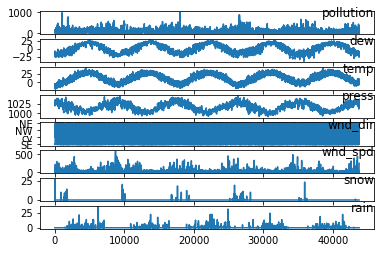

In [9]:
# 设置需要可视化的列表
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# 数据探索EDA
plt.figure()
for group in range(8):
    plt.subplot(8, 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [10]:
# 将分类特征wnd_dir 进行标签编码
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# 设置数据类型均为flast32
values = values.astype('float32')
#pd.DataFrame(values).to_csv('values.csv')
print(values)

[[129.   -16.    -4.   ...   1.79   0.     0.  ]
 [148.   -15.    -4.   ...   2.68   0.     0.  ]
 [159.   -11.    -5.   ...   3.57   0.     0.  ]
 ...
 [ 10.   -22.    -3.   ... 242.7    0.     0.  ]
 [  8.   -22.    -4.   ... 246.72   0.     0.  ]
 [ 12.   -21.    -3.   ... 249.85   0.     0.  ]]


In [11]:
# 对所有数据进行0-1规范化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

(43800, 8)


In [12]:
# 将时间序列数据转换为适合监督学习的数据
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
reframed.to_csv('reframed-1.csv')

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
...          ...        ...        ...        ...        ...        ...   
43795   0.010060   0.264706   0.278689   0.763638   0.333333   0.385730   
43796   0.008048   0.250000   0.278689   0.781818   0.333333   0.395659   
43797   0.010060   0.264706   0.262295   0.781818   0.333333   0.405588   
43798   0.010060   0.264706   0.262295   0.781818   0.333333   0.413996   
43799   0.008048   0.264706   0.245902   0.781818   0.333333   0.420866   

       var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1       0.000000  

In [13]:
# 去掉不需要预测的列，即var2(t) var3(t) var4(t) var5(t) var6(t)var7(t)var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.to_csv('reframed-2.csv')
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [14]:
# 训练集80%，测试集20%
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [23]:
# :-1表示从0到数组最后一位，-1表示数组最后一位
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)

(35039, 8)


In [24]:
# 转换成3D格式 [样本数, 时间步, 特征数]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [25]:
train_X

array([[[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001,
         0.        , 0.        ]],

       [[0.14889336, 0.36764708, 0.24590163, ..., 0.00381099,
         0.        , 0.        ]],

       [[0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197,
         0.        , 0.        ]],

       ...,

       [[0.01810865, 0.2794118 , 0.42622948, ..., 0.20394772,
         0.        , 0.        ]],

       [[0.02313883, 0.2794118 , 0.42622948, ..., 0.2138768 ,
         0.        , 0.        ]],

       [[0.02012072, 0.2794118 , 0.40983605, ..., 0.22228491,
         0.        , 0.        ]]], dtype=float32)

In [17]:
# 设置网络模型
model = Sequential()
print('shape = ', train_X.shape)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]))) # 1,8, train_X.shape = (35039, 1, 8)
print(test_X.shape[2])
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# 模型训练, verbose = 2 为每个epoch输出一行记录, =1为输出进度条记录, =0 不在标准输出流输出日志信息
result = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

shape =  (35039, 1, 8)
8
Epoch 1/10
1095/1095 - 4s - loss: 0.0021 - val_loss: 0.0021
Epoch 2/10
1095/1095 - 1s - loss: 8.0844e-04 - val_loss: 0.0011
Epoch 3/10
1095/1095 - 1s - loss: 8.0661e-04 - val_loss: 0.0011
Epoch 4/10
1095/1095 - 1s - loss: 8.1072e-04 - val_loss: 0.0011
Epoch 5/10
1095/1095 - 1s - loss: 8.0958e-04 - val_loss: 0.0011
Epoch 6/10
1095/1095 - 1s - loss: 8.0745e-04 - val_loss: 0.0011
Epoch 7/10
1095/1095 - 1s - loss: 8.0525e-04 - val_loss: 0.0011
Epoch 8/10
1095/1095 - 1s - loss: 8.0317e-04 - val_loss: 0.0011
Epoch 9/10
1095/1095 - 1s - loss: 8.0126e-04 - val_loss: 0.0011
Epoch 10/10
1095/1095 - 1s - loss: 7.9955e-04 - val_loss: 0.0011


In [18]:
# 模型预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

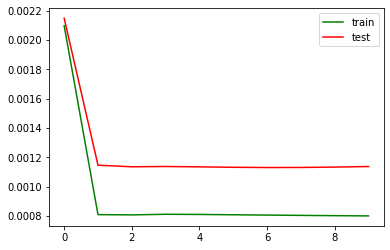

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# 绘制训练损失和测试损失
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc='best')
plt.show()
print(model.summary())

D:\anaconda\envs\work\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


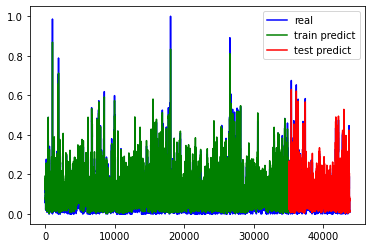

In [20]:
# 呈现原始数据，训练结果，预测结果
def plot_img(source_data_set, train_predict, test_predict):
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], label='real', c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], label='train predict', c='g')
    # 预测结果红色
    plt.plot([None for _ in train_predict] + [x for x in test_predict], label='test predict', c='r')
    plt.legend()
    plt.show()

# 绘制预测结果与实际结果对比
plot_img(values, train_predict, test_predict)